# Project 3: Regression problem using Gurobi and Lasso

| Name | EID |
| --- | --- |
| Praneet Kumar Alamuri|pa22222 |
| Kshitij Mahajan| ksm3267 |
| Shubhada Kapre | sk55489 |
| Leyanng Xu| clw4642 |

In [ ]:
!pip install gurobipy
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme()
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
################################################################
GUROBI_TIME_LIMIT = 360
################################################################
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

np.random.seed(seed=42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 5.2 MB/s 


## Data pre-processing

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/KshitijMahajan1998/Optimization/main/training_data.csv')
test = pd.read_csv('https://raw.githubusercontent.com/KshitijMahajan1998/Optimization/main/test_data.csv')

# Separate dependant and independant variables
X_train_old, y_train_old= train.drop(columns='y').to_numpy(), train['y'].to_numpy()

train_df = train.copy()
train_df.insert(1,column='X0',value=np.ones(len(train)))

test_df =test.copy()
test_df.insert(1,column='X0',value=np.ones(len(test)))

train_df.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.53615,1.00000,-1.53541,0.71889,-2.09915,-0.44284,-0.59898,-1.64257,0.20776,0.76064,...,0.36187,1.79310,-0.63129,-0.06175,0.51105,0.48875,-0.61277,-0.47105,-1.13978,-0.26077
1,4.80834,1.00000,-1.73461,0.55198,-2.14767,-1.55294,1.51491,-1.14397,0.73759,1.32124,...,-0.67798,-0.16568,0.06540,0.13716,1.25820,-0.12083,-1.56483,-0.24256,-0.00183,1.18745
2,-1.53043,1.00000,0.09726,0.10763,-0.19422,0.33545,-0.40820,0.13326,0.70618,0.39497,...,1.10880,0.33379,0.28205,-1.08629,-0.11535,0.25786,-0.08884,-0.75123,1.45061,0.29059
3,-0.42824,1.00000,-0.06770,0.55784,0.70085,-1.12138,1.72227,0.61353,0.70091,-0.41798,...,0.69251,-0.35099,0.62456,0.43452,-0.36741,-1.14468,-0.13652,-0.55721,0.41630,0.48449
4,0.56669,1.00000,0.48873,0.21148,0.56839,0.64684,0.16387,-0.00215,0.12514,0.49357,...,-0.00060,1.07528,0.18228,-1.13846,0.10609,0.54464,-0.38349,-0.42577,2.66765,-0.05075


In [ ]:
# Get a list of shuffled indices from the training data and use the indices to create a new, shuffled training df
shuffled_index = np.random.permutation(train_df.index)
shuffled_train = train_df.iloc[shuffled_index]

# Separate out the X and y variables from the training and test sets. 
X_train, y_train = shuffled_train.drop(columns='y').to_numpy(), shuffled_train['y'].to_numpy()
X_test, y_test = test_df.drop(columns='y').to_numpy(), test_df['y'].to_numpy()

Now , we need to get our k_fold indices. 


In [ ]:
k_folds = 10
split_indices = KFold(n_splits=k_folds).split(X_train)

k_folds_dict=dict() 
for i, indices in enumerate(split_indices):
    index_dict = {}
    # The training indices are in the first item of the tuple and the testing indices are in the second.
    index_dict['train_indices'] = indices[0]
    index_dict['test_indices'] = indices[1]
    k_folds_dict[i] = index_dict

# Sample of the dicitionary printed for the first fold
print(k_folds_dict[0])

{'train_indices': array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201,

## Select the optimal K value with Gurobi

In [ ]:
# Create a dataframe to store the cross validation results for the gurobi optimization

options_for_k = np.arange(5,51,5)

gurobi_results = pd.DataFrame(index=k_folds_dict.keys(),columns=options_for_k )


Initialize basic parameters

In [ ]:
M = 50 

# Number of independent variables in our problem.
beta = X_train.shape[1] - 1

# The betas are continuous, but the z variables will be binary
v_type = ['C']*(beta+1) + ['B']*beta

# Betas can be negative in this problem. But the z variables are binary 1/0
lower_bounds = [-M]*(beta+1) + [0]*beta

In [ ]:
def solve_gurobi(X,y,k):
    """Returns an array of the 51 beta coefficients  which are optimal betas, solved with gurobi.
    Inputs: X and y data as numpy arrays. And the k value.
    """

    # Create the matrices for the quadratic and linear objective functions
    quadratic_obj = np.zeros(shape=(2*beta+1,2*beta+1))
    quadratic_obj[:(beta+1),:(beta+1)] = X.T @ X

    linear_obj = np.zeros(shape=beta*2+1)
    linear_obj[:(beta+1)] = -2*y.T @ X


    
    sense = []
    b = []

    # We need two big M constraints for each beta and 1 constraint to make sure beta number = k 
    num_constraints = beta * 2 + 1
    A = np.zeros(shape=(num_constraints,len(linear_obj)))


    # Constraint that the number of independent betas should sum to <= k. Excludes the intercept beta.
    A[0,(beta+1):] = 1
    sense.append('<')
    b.append(k)

    # Add the big M constraints
    # Skip the intercept term 
    # Start on row index 1 (because 0 is set above)
    row_index = 1
    for i in range(1,beta+1):
        # Set constraint that beta must be less than M
        A[row_index,i] = 1
        A[row_index, i + beta] = -M
        sense.append('<')
        b.append(0)
        row_index += 1

        # Set constraint that beta must be greater than -M
        A[row_index,i] = 1
        A[row_index, i + beta] = M
        sense.append('>')
        b.append(0)

        row_index += 1

    #Solve using Gurobi
    regression = gp.Model()
    
    regression_x = regression.addMVar(len(linear_obj), lb=lower_bounds, vtype=v_type)
    portMod_con = regression.addMConstr(A, regression_x, sense, b)
    regression.setMObjective(quadratic_obj,linear_obj,0,sense=gp.GRB.MINIMIZE)

    regression.Params.OutputFlag = 0 
    regression.Params.TimeLimit = GUROBI_TIME_LIMIT
    regression.optimize()

    # Return all of the betas as the results!!
    return regression_x.x[:(beta+1)]

# pd.DataFrame(solve_gurobi(X_train,y_train,10))

Functions for prediction and calculating SSE

In [ ]:
def predict_y(X, betas):
    """Outputs the predicted y values"""
    return X @ betas

def sse(y_true, y_predict):
    """Returns the sum of squared errors."""
    return sum((y_true - y_predict)**2)

In [ ]:


for k_fold, indices_dict in k_folds_dict.items():

    # Get our training folds and testing folds
    X_train_folds, y_train_folds = X_train[indices_dict['train_indices']], y_train[indices_dict['train_indices']]
    X_test_fold, y_test_fold = X_train[indices_dict['test_indices']], y_train[indices_dict['test_indices']]

    # Now let's try out all of the possible k values
    for k in options_for_k:
        optimal_betas = solve_gurobi(X_train_folds,y_train_folds,k)

        validation_mse = sse(y_test_fold,predict_y(X_test_fold,optimal_betas))

        gurobi_results.loc[k_fold,k] = validation_mse  

gurobi_results.to_csv('gurobi_sse_results.csv',index=False)

gurobi_results

,5,10,15,20,25,30,35,40,45,50
0,121.08483,83.22601,84.98515,82.43595,87.58834,95.66110,97.65884,97.40345,96.66076,97.57031
1,76.27096,68.72295,85.44507,91.70347,87.32446,95.86751,96.42208,96.91586,100.55214,101.13772
2,76.40846,62.50184,70.91066,83.65107,75.81232,73.46238,78.72707,80.83133,80.58768,79.96562
3,72.64028,62.72359,71.70770,71.71293,70.69936,79.46967,76.85514,77.86652,77.24967,78.33711
4,118.95958,82.00438,83.84794,80.40048,80.64813,86.74073,90.89855,87.67083,85.88534,86.93229
5,82.97925,61.88108,65.54801,59.53692,75.45312,67.36771,61.14406,66.13959,67.73551,67.36372
6,76.18434,65.08857,69.81931,70.62222,68.35383,70.47346,67.89549,71.89055,74.54640,75.06871
7,60.29282,48.66334,59.89032,58.02635,56.43211,55.66685,54.96695,60.79733,64.49536,63.55508
8,133.75785,93.39369,99.85986,105.95280,98.82562,105.08918,104.69604,103.96380,104.82810,104.08194
9,95.53616,75.76057,87.45220,89.38065,81.48977,84.18368,88.06178,84.99322,84.14878,86.44153


In [ ]:

sse_per_fold = gurobi_results.sum()
pd.DataFrame(sse_per_fold,columns=['Total SSE'])

,Total SSE
5,914.11453
10,703.96601
15,779.46622
20,793.42285
25,782.62708
30,813.98226
35,817.32599
40,828.47247
45,836.68975
50,840.45402


We can plot the results to see how the total error evolves as the K changes.

Text(0, 0.5, 'Aggregate SSE Across All Folds')

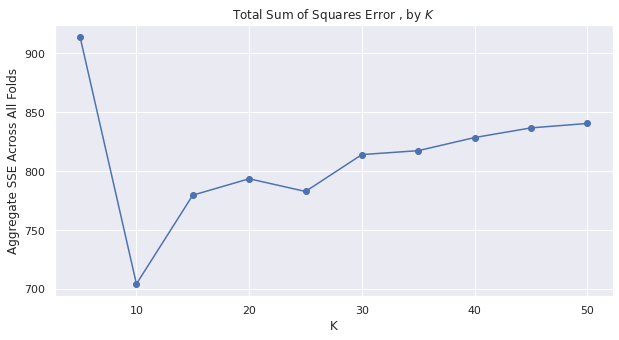

In [ ]:
sse_per_fold.plot(figsize=(10,5),marker='o')
plt.title('Total Sum of Squares Error , by $K$')
plt.xlabel('K')
plt.ylabel('Aggregate SSE Across All Folds')

We are able to capture a minimum here where k = 10.

In [ ]:
# Store the best K for later use
best_k = int(sse_per_fold.sort_values().index[0])
print(f'The best K = {best_k}')

The best K = 10


Fit the entire data set using the best k calculated above and finally, test on the hold out set.

In [ ]:

best_results = pd.DataFrame(columns=['SSE','MSE','R_Squared'])

In [ ]:
# Create and fit the model with the best K
best_gurobi_betas = solve_gurobi(X_train,y_train,k=best_k)


gurobi_predictions = predict_y(X_test,best_gurobi_betas)
gurobi_sse = sse(y_test,gurobi_predictions)
gurobi_mse = mean_squared_error(y_test,gurobi_predictions)
gurobi_r_squared = r2_score(y_test,gurobi_predictions)

best_results.loc['Gurobi_Method'] = [gurobi_sse,gurobi_mse,gurobi_r_squared]
best_results

,SSE,MSE,R_Squared
Gurobi_Method,116.82720,2.33654,0.85867


## Picking Lambda with scikitlearn

In [ ]:
lasso_model_cv = linear_model.LassoCV(cv=10).fit(X_train_old,y_train_old)
best_lambda = lasso_model_cv.alpha_
print(f'The best lambda = {best_lambda}')

The best lambda = 0.07638765995113514


Fit the entire data set using the best lambda calculated above and finally, test on the hold out set.

In [ ]:
# Create and fit the best lasso.
lasso_model = Lasso(best_lambda).fit(X_train_old, y_train_old)

# Predict on hold out set and put the metrics into the best results df

lasso_predictions = lasso_model.predict(X_test[:,1:])
lasso_sse = sse(y_test,lasso_predictions)
lasso_mse = mean_squared_error(y_test,lasso_predictions)
lasso_r_squared = r2_score(y_test,lasso_predictions)

best_results.loc['Lasso_Metrics'] = [lasso_sse, lasso_mse, lasso_r_squared]

## Comparison

In [ ]:
best_results

,SSE,MSE,R_Squared
Gurobi_Method,116.82720,2.33654,0.85867
Lasso_Metrics,117.48174,2.34963,0.85788


In [ ]:
print(f'The number of  betas using the lasso method =  {(lasso_model.coef_ != 0).sum()}')
print(f'The number of  betas using the Gurobi Optimization method =  {(best_gurobi_betas != 0).sum()-1}')

The number of  betas using the lasso method =  17
The number of  betas using the Gurobi Optimization method =  10


In [ ]:
lasso=dict()
for i in range(len(lasso_model.coef_)):
  y='x'+str(i+1)
  lasso[y]=lasso_model.coef_[i]
lasso

{'x1': -0.0,
 'x2': -0.0,
 'x3': 0.0,
 'x4': 0.0,
 'x5': -0.0,
 'x6': 0.0,
 'x7': -0.0,
 'x8': -0.0,
 'x9': -2.1605476452260297,
 'x10': 0.0,
 'x11': -0.05964031098134874,
 'x12': -0.0,
 'x13': -0.0,
 'x14': -0.0,
 'x15': -0.41912484407542994,
 'x16': -0.19325407849784226,
 'x17': 0.0,
 'x18': 0.0,
 'x19': -0.0,
 'x20': 0.0,
 'x21': 0.0,
 'x22': -0.19517758964637522,
 'x23': -1.363887375193064,
 'x24': 0.7425965005682696,
 'x25': -0.0,
 'x26': -1.3048157442977075,
 'x27': -0.0,
 'x28': 0.0,
 'x29': 0.05798283048603748,
 'x30': 0.0,
 'x31': -0.0,
 'x32': 0.0,
 'x33': -0.09737838635372846,
 'x34': 0.2834162868334561,
 'x35': 0.0,
 'x36': 0.0,
 'x37': 0.0,
 'x38': 0.0,
 'x39': -0.23157872750798203,
 'x40': 0.0,
 'x41': -0.0,
 'x42': 0.0,
 'x43': 0.0,
 'x44': 0.030781912040408668,
 'x45': 1.563621715601988,
 'x46': -0.021600326247110318,
 'x47': 0.6999244711955707,
 'x48': -0.09289744743686544,
 'x49': 0.0,
 'x50': 0.0}

In [ ]:

Gurobi=dict()
for i in range(50):
  y='x'+str(i+1)
  Gurobi[y]=best_gurobi_betas[i]

Gurobi

{'x1': 0.9725240765514848,
 'x2': 0.0,
 'x3': 0.0,
 'x4': 0.0,
 'x5': 0.0,
 'x6': 0.0,
 'x7': 0.0,
 'x8': 0.0,
 'x9': 0.0,
 'x10': -2.308207261938351,
 'x11': 0.0,
 'x12': 0.0,
 'x13': 0.0,
 'x14': 0.0,
 'x15': 0.0,
 'x16': -0.5183261233652076,
 'x17': -0.20416201346654356,
 'x18': 0.0,
 'x19': 0.0,
 'x20': 0.0,
 'x21': 0.0,
 'x22': 0.0,
 'x23': 0.0,
 'x24': -1.5591431785888534,
 'x25': 0.8669733628924517,
 'x26': 0.0,
 'x27': -1.311919415122682,
 'x28': 0.0,
 'x29': 0.0,
 'x30': 0.0,
 'x31': 0.0,
 'x32': 0.0,
 'x33': 0.0,
 'x34': 0.0,
 'x35': 0.4081653033058826,
 'x36': 0.0,
 'x37': 0.0,
 'x38': 0.0,
 'x39': 0.0,
 'x40': 0.0,
 'x41': 0.0,
 'x42': 0.0,
 'x43': 0.0,
 'x44': 0.0,
 'x45': 0.0,
 'x46': 1.781474891076474,
 'x47': 0.0,
 'x48': 0.8873829240125514,
 'x49': -0.28229212764205974,
 'x50': 0.0}

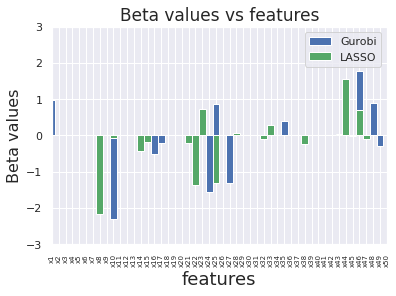

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


X = np.arange(len(Gurobi))
ax = plt.subplot(111)
ax.set_xlim(0,0.001)
ax.set_ylim(-3,3)
ax.bar(X, Gurobi.values(), width=1, color='b', align='center')
ax.bar(X-1, lasso.values(), width=1, color='g', align='center')
ax.legend(('Gurobi','LASSO'))
plt.xticks(X, lasso.keys())
plt.title("Beta values vs features", fontsize=17)
plt.xlabel('features', fontsize=18)
plt.ylabel('Beta values', fontsize=16)
plt.xticks(fontsize=7, rotation=90)
plt.show()